## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [30]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from tacotron2.hparams import create_hparams
from tacotron2.model import Tacotron2
from tacotron2.layers import TacotronSTFT, STFT
from tacotron2.audio_processing import griffin_lim
from tacotron2.train import load_model
from tacotron2.text import text_to_sequence
from waveglow.denoiser import Denoiser

In [18]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='lower', 
                       interpolation='none')

#### Setup hparams

In [19]:
hparams = create_hparams()
hparams["sampling_rate"] = 22050

#### Load model from checkpoint

In [20]:
checkpoint_path = "tacotron2_statedict.pt"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu'))['state_dict'])
#_ = model.cuda().eval().half()
# also modified train.py line:74

_ = model.eval()

In [21]:
print(model)

Tacotron2(
  (embedding): Embedding(148, 512)
  (encoder): Encoder(
    (convolutions): ModuleList(
      (0): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (prenet): Prenet(
      (layers): ModuleList(
        (0): LinearNorm(
          (lin

#### Load WaveGlow for mel2audio synthesis and denoiser

In [22]:
waveglow_path = 'waveglow_256channels_universal_v5.pt'
waveglow = torch.load(waveglow_path)['model']
#waveglow.cuda().eval().half()
# modified denoiser.py line:15
# modified glow.py line:268
# modified glow.py line:298
waveglow.eval()#.half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'glow.WaveGlow' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.container.Modu

In [23]:
print(denoiser)

Denoiser(
  (stft): STFT()
)


#### Prepare text input

In [24]:
text = "This finally worked!"
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    #torch.from_numpy(sequence)).cuda().long()
    torch.from_numpy(sequence)).long()

#### Decode text input and plot results

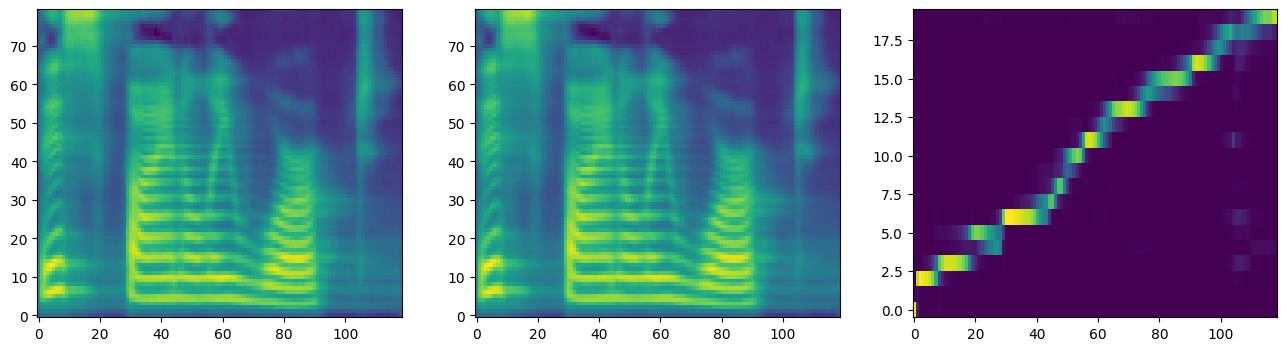

In [31]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [32]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
print(audio.shape)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams["sampling_rate"])

torch.Size([1, 30464])


#### (Optional) Remove WaveGlow bias

In [27]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams["sampling_rate"]) 

AssertionError: Torch not compiled with CUDA enabled